In [1]:
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images, split_data_into_channels, merge_channels_into_data
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection
import astropy.units as u
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.background import Background2D

In [2]:
# Set up the directories
base_dir = Path.home() / "Data/observing/winter/"

night = "20250220_C2"
# night = "20250220_C"

target_dir = base_dir / night / "final"

out_dir = target_dir.parent / "crosscheck"
out_dir.mkdir(exist_ok=True)
# print(base_dir)
# name = 'ZTF25aadlqhw'
# night = '20250220'
# boardid = 4

# target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

In [3]:
raw_list = list(target_dir.glob("*0.fits"))
print(f"Found {len(raw_list)} raw files in {target_dir}")

Found 8 raw files in /Users/rdstein/Data/observing/winter/20250220_C2/final


Loading /Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-072926-636_mef_4_0_0.fits
(1096, 1984)
(16, 16)


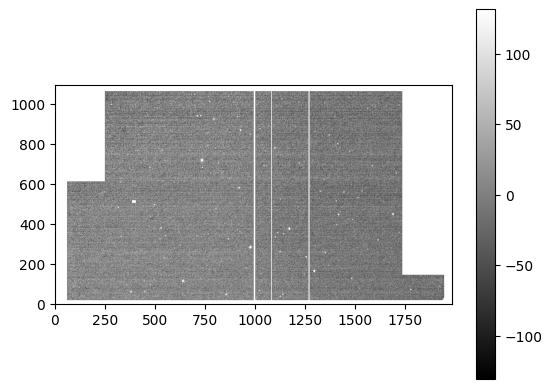

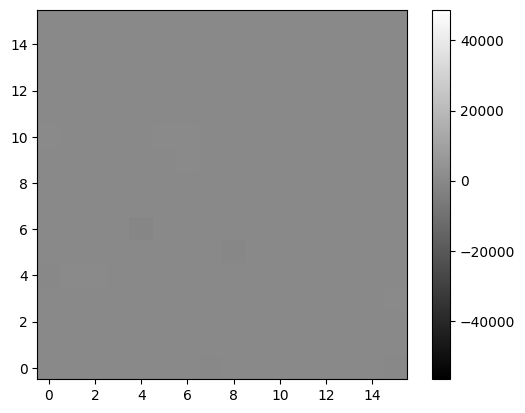

In [4]:
# Load a raw_unpacked file
img_file = raw_list[0]
print(f"Loading {img_file}")
raw_img = fits.getdata(target_dir.joinpath('raw_unpacked', img_file))
from astropy.visualization import ImageNormalize
norm = ImageNormalize(vmin=12000, vmax = 40000)
plot_image(raw_img)

print(raw_img.shape)

roi_center = [312, 1215]
roi_width = 16
roi_height = 16
roi_coords = [roi_center[0] - roi_height//2, roi_center[0] + roi_height//2, roi_center[1] - roi_width//2, roi_center[1] + roi_width//2]
roi = raw_img[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
# astropy visualization norm:
norm = ImageNormalize(vmin=np.nanmin(raw_img), vmax = np.nanmax(raw_img))
plot_image(roi, norm=norm)
print(roi.shape)

shape of channels: (8, 4)
norm: <astropy.visualization.mpl_normalize.ImageNormalize object at 0x110391430>


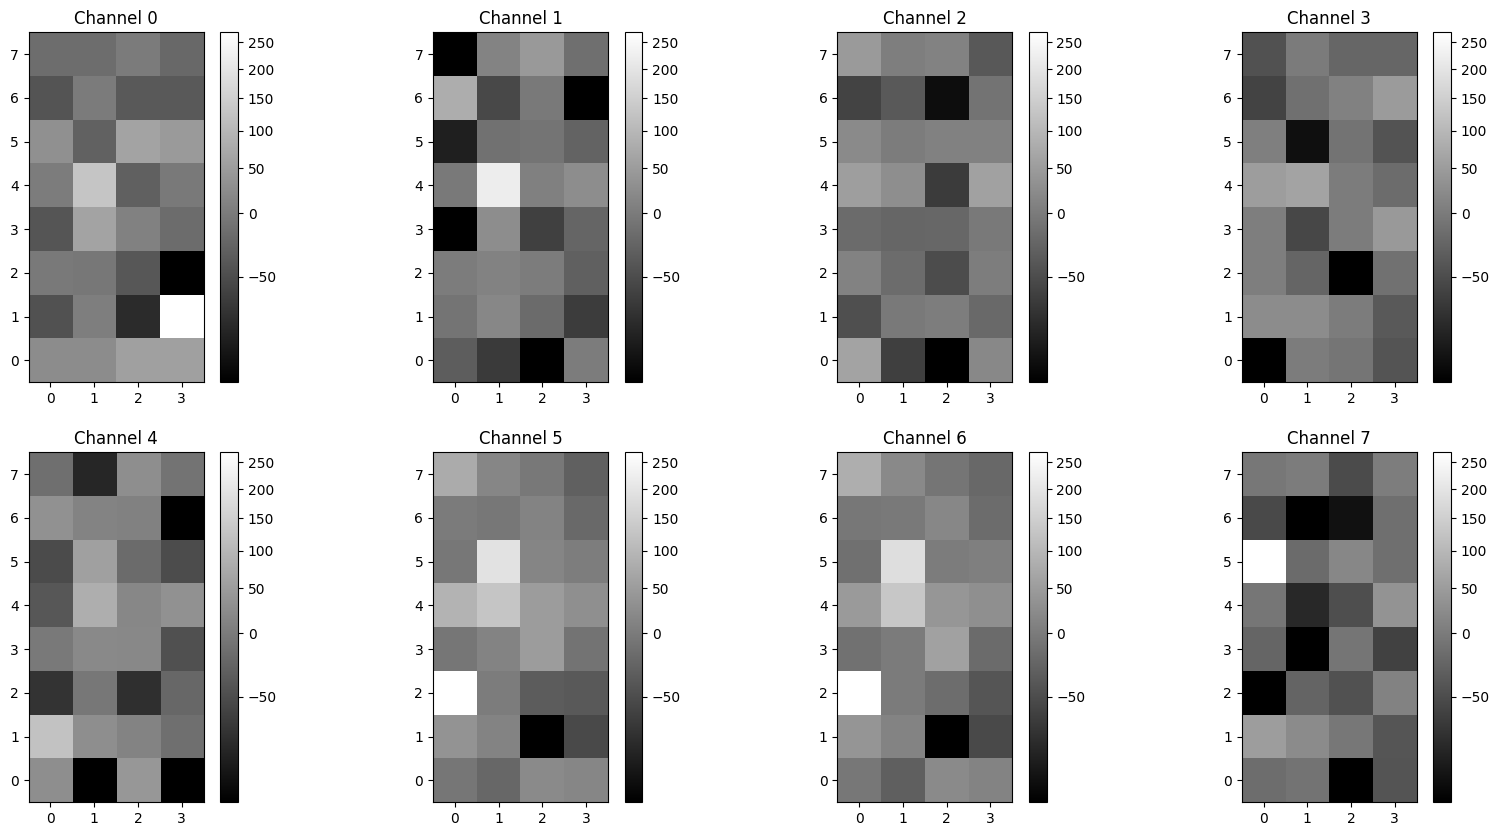

In [5]:
# Split the data up into channels
channels = split_data_into_channels(roi)
print(f"shape of channels: {channels[0].shape}")

# plot all the 8 channels. use the same color scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # if it's the first image, grab the normalization 
    if i==0:
        ax, norm = plot_image(channels[i], ax=ax, return_norm=True, norm = "zscale")
        print(f"norm: {norm}")
    else:
        plot_image(channels[i], ax=ax, norm=norm)
    ax.set_title(f"Channel {i}")
    

plt.show()




In [6]:
# Run sextractor on the skysubtracted image. With regions=True, a regions file
# with all detected sources is written in the target directory.

def get_xmatch_catalog(path: Path):
    image_catalog = get_table_from_ldac(path)
    image_catalog = image_catalog[(image_catalog['MAG_AUTO'] < 99) & (image_catalog['MAG_PSF'] < 99) & (image_catalog['FLAGS']==0) & (image_catalog['FWHM_WORLD']<4.0/3600.0)]
    print(f"Found {len(image_catalog)} good sources in the catalog")

    ref_cat = get_table_from_ldac(path.with_suffix(".local.cat"))
    print(f"Found {len(ref_cat)} good sources in the ref catalog")

    xmatch_cat, xmatch_ref_cat = xmatch_img_ref_cats(image_catalog, ref_cat, xmatch_radius_arcsec=2)
    print(f"Found {len(xmatch_cat)} matched sources")

    return xmatch_cat, xmatch_ref_cat

APER_RANGE = list(range(2, 9))

def get_all_xmatch_cats(parent_dir: Path):
    res = dict()
    all_zps = dict()
    
    cats = list(parent_dir.glob("WINTER*0.cat"))
    for cat in cats:
        (new, ref) = get_xmatch_catalog(cat)

        for i in APER_RANGE:
            new[f"MAG_APER_{i}"] = [x[i-2] for x in new["MAG_APER"]]
            new[f"FLUX_APER_{i}"] = [x[i-2] for x in new["FLUX_APER"]]

        res[cat.name] = (new, ref)
        

        path = cat.parent.parent / "final" / cat.with_suffix(".fits").name

        with fits.open(path) as hdul:
            all_zps[cat.name] = hdul[0].header["ZP"]
    
        

    return res, all_zps
    
# catname = run_sextractor(skysub_scamped_filename, weightimg=None, regions=True)

In [7]:
all_xmatch, all_zps = get_all_xmatch_cats(target_dir.parent / "phot")

Found 1412 good sources in the catalog
Found 191 good sources in the ref catalog
Found 42 matched sources
Found 200 good sources in the catalog
Found 192 good sources in the ref catalog
Found 79 matched sources
Found 1100 good sources in the catalog
Found 195 good sources in the ref catalog
Found 44 matched sources
Found 230 good sources in the catalog
Found 200 good sources in the ref catalog
Found 73 matched sources
Found 159 good sources in the catalog
Found 194 good sources in the ref catalog
Found 83 matched sources
Found 1231 good sources in the catalog


Found 191 good sources in the ref catalog
Found 52 matched sources
Found 127 good sources in the catalog
Found 193 good sources in the ref catalog
Found 71 matched sources
Found 179 good sources in the catalog
Found 200 good sources in the ref catalog
Found 71 matched sources


In [8]:
all_zps

{'WINTERcamera_20250221-074002-803_mef_4_0_0.cat': 24.78801412567203,
 'WINTERcamera_20250221-073134-464_mef_4_0_0.cat': 24.692815663351528,
 'WINTERcamera_20250221-073755-706_mef_4_0_0.cat': 24.77736405386779,
 'WINTERcamera_20250221-072719-143_mef_4_0_0.cat': 24.86435127094728,
 'WINTERcamera_20250221-073548-506_mef_4_0_0.cat': 24.908356173291452,
 'WINTERcamera_20250221-072926-636_mef_4_0_0.cat': 24.947184089324463,
 'WINTERcamera_20250221-074210-516_mef_4_0_0.cat': 24.865133071512833,
 'WINTERcamera_20250221-073341-459_mef_4_0_0.cat': 24.861500803866278}

# MAG_AUTO

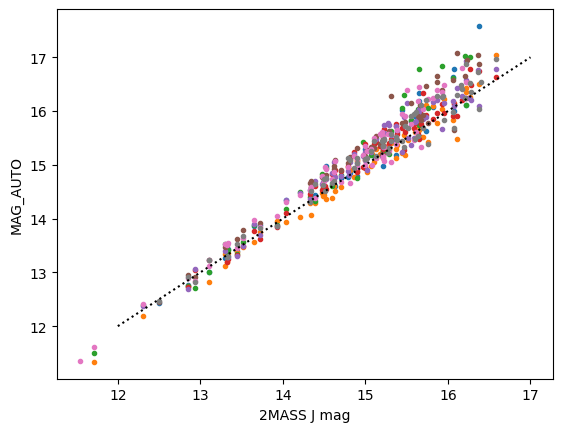

In [9]:
for key, (cat, ref) in all_xmatch.items():
    zp = all_zps[key]
    plt.plot(ref['j_m'], cat['MAG_AUTO'] + zp, '.')
plt.plot([12., 17.], [12., 17.], linestyle=":", color="k")
plt.ylabel('MAG_AUTO')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_auto.pdf")

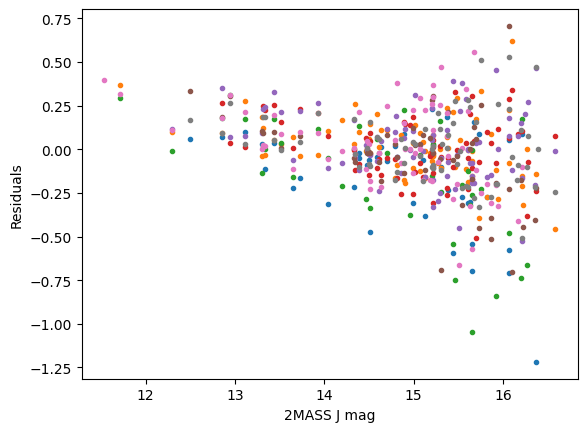

In [10]:
res_df = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_AUTO'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_AUTO'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df = pd.DataFrame(res_df)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_auto.pdf")

Median: -0.00, std: 0.23 
 ZP: 24.71, zpstd 0.06, nstars: 235


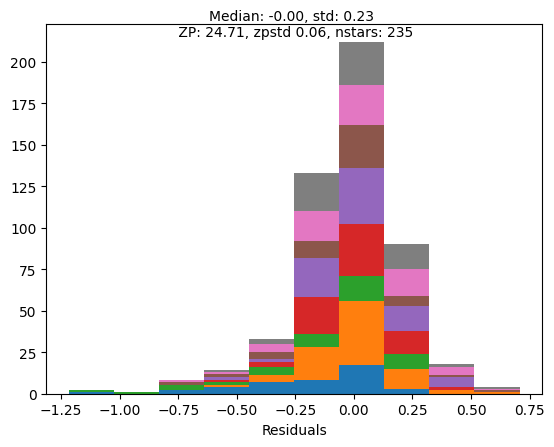

In [11]:
plt.hist(res_df["residuals"], stacked=True,)
all_residuals = [x for y in res_df["residuals"]for x in y]

txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df["zp"].median():.2f}, zpstd {res_df["zpstd"].median():.2f}, nstars: {res_df["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_auto.pdf",
    bbox_inches="tight",
)

# MAG_PSF

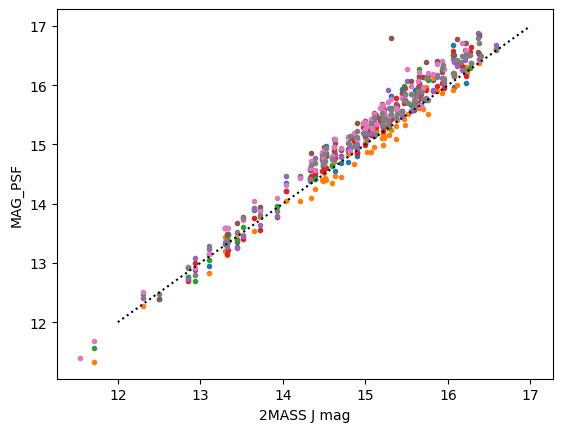

In [12]:
for key, (cat, ref) in all_xmatch.items():
    zp = all_zps[key] - 0.3
    plt.plot(ref['j_m'], cat['MAG_PSF'] + zp, '.')

plt.plot([12., 17.], [12., 17.], linestyle=":", color="k")
plt.ylabel('MAG_PSF')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_psf.pdf")

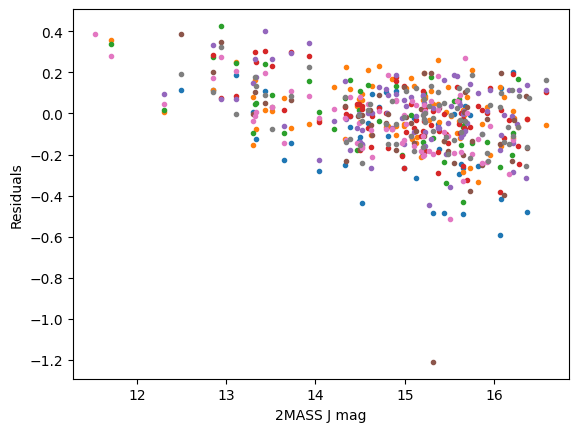

In [13]:
res_df_psf = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_PSF'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_PSF'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df_psf.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df_psf = pd.DataFrame(res_df_psf)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_psf.pdf")

Median: -0.01, std: 0.17 
 ZP: 24.39, zpstd 0.06, nstars: 250


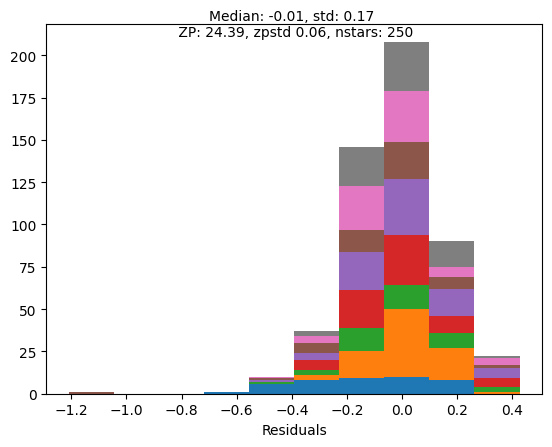

In [14]:
plt.hist(res_df_psf["residuals"], stacked=True)
all_residuals = [x for y in res_df_psf["residuals"] for x in y]
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_psf["zp"].median():.2f}, zpstd {res_df_psf["zpstd"].median():.2f}, nstars: {res_df_psf["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_psf.pdf",
    bbox_inches="tight",
)

# MAG_APER

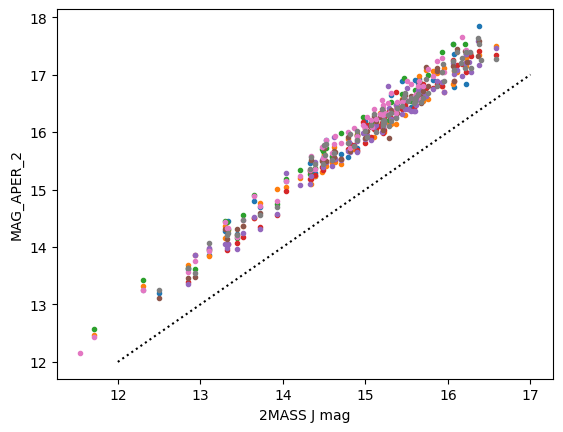

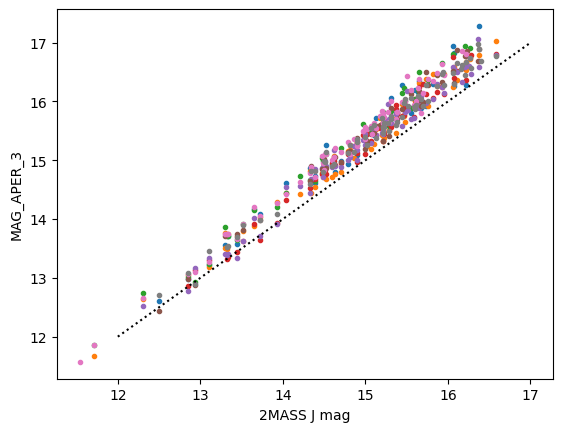

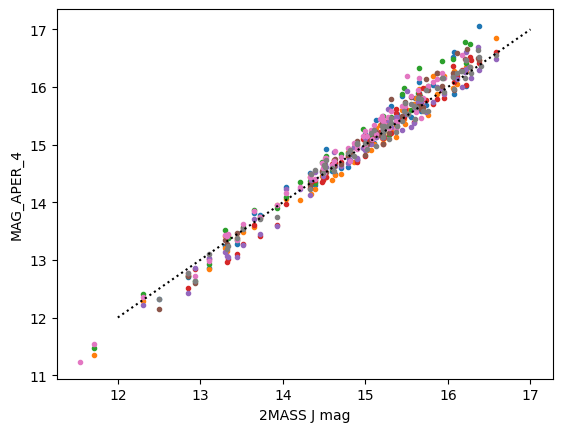

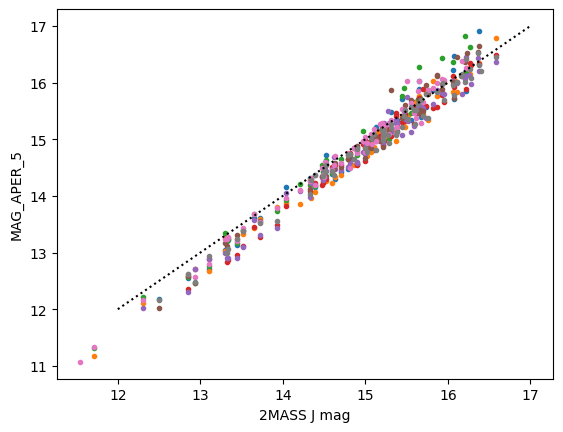

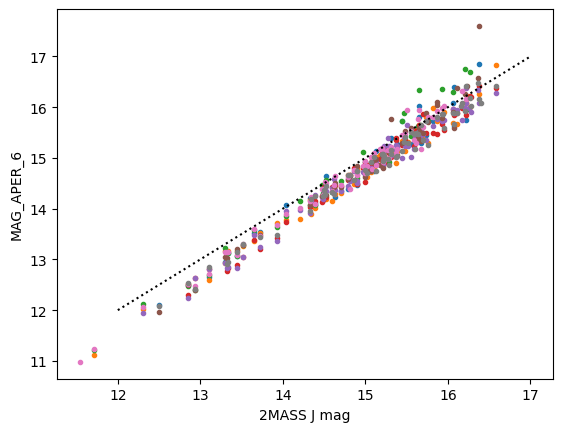

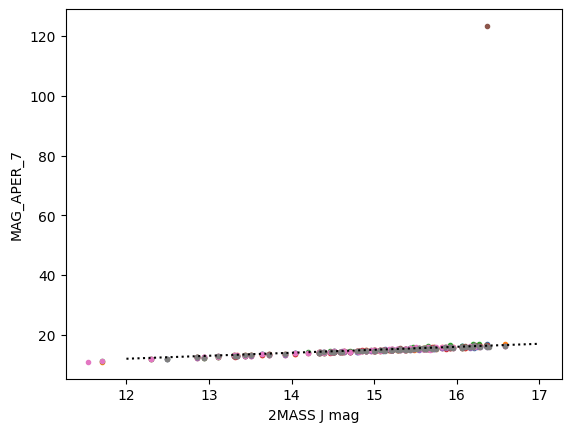

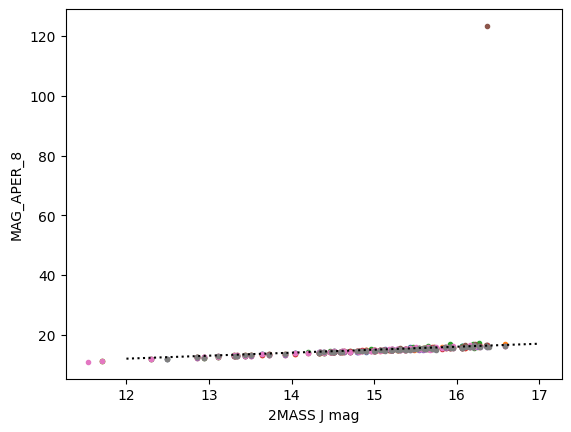

In [15]:
for key in APER_RANGE:
    plt.figure()

    var = f'MAG_APER_{key}'

    for key, (cat, ref) in all_xmatch.items():
        # zp = all_zps[key] - 1.2
        plt.plot(ref['j_m'], cat[var] + zp, '.')
    
    plt.plot([12., 17.], [12., 17.], linestyle=":", color="k")
    
    plt.ylabel(var)
    plt.xlabel('2MASS J mag')
    plt.savefig(out_dir / f"scatter_aper_{key}.pdf")

Median: -0.01, std: 0.17 
 ZP: 23.40, zpstd 0.04, nstars: 223
Median: -0.01, std: 0.17 
 ZP: 24.04, zpstd 0.05, nstars: 236
Median: -0.00, std: 0.18 
 ZP: 24.35, zpstd 0.05, nstars: 244
Median: 0.01, std: 0.19 
 ZP: 24.50, zpstd 0.04, nstars: 235
Median: 0.00, std: 0.20 
 ZP: 24.59, zpstd 0.05, nstars: 245
Median: -0.01, std: 4.72 
 ZP: 24.65, zpstd 0.05, nstars: 252
Median: -0.02, std: 4.73 
 ZP: 24.69, zpstd 0.05, nstars: 236


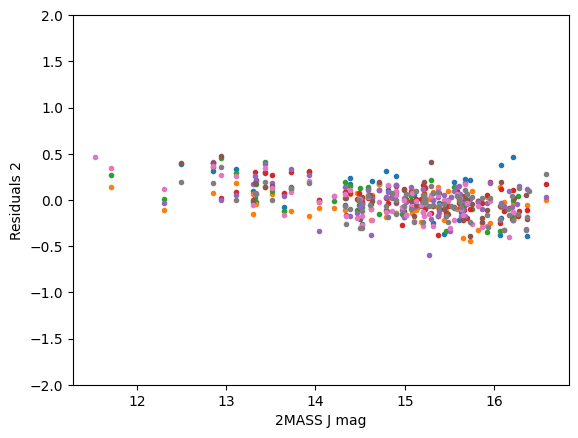

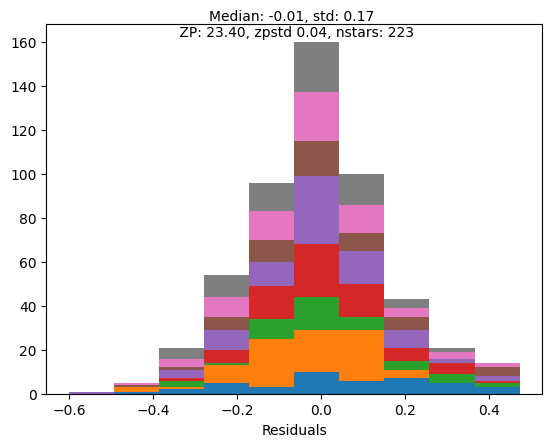

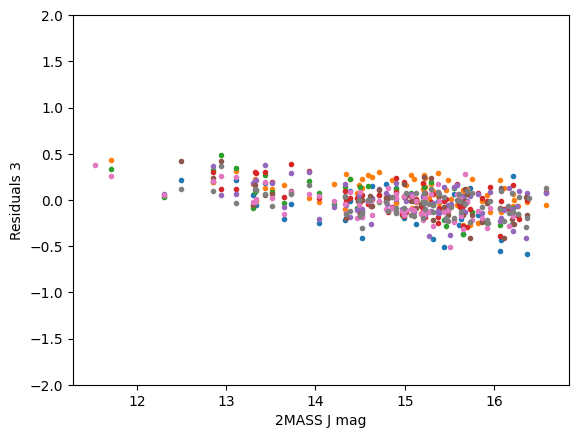

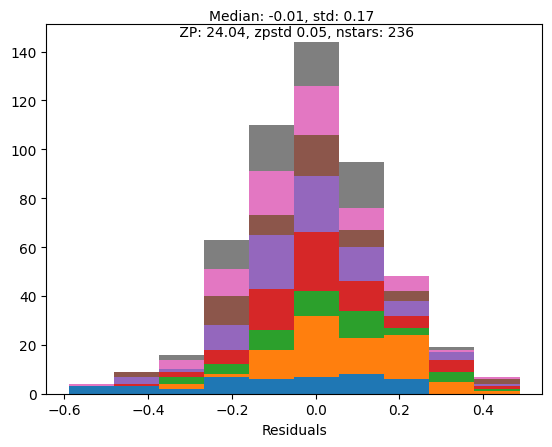

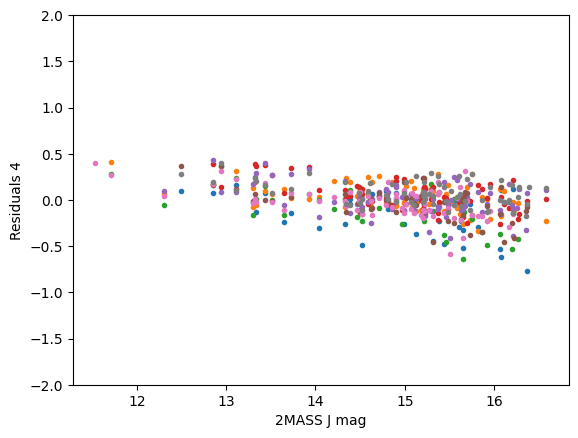

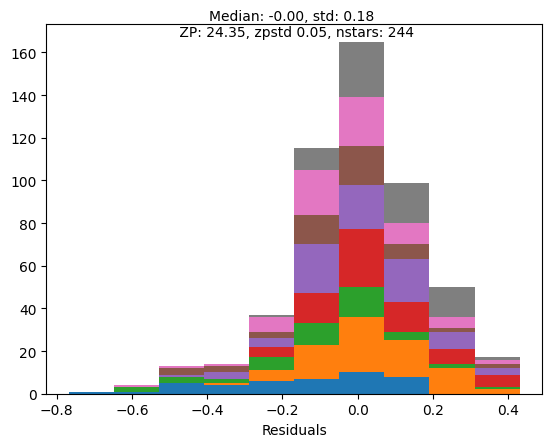

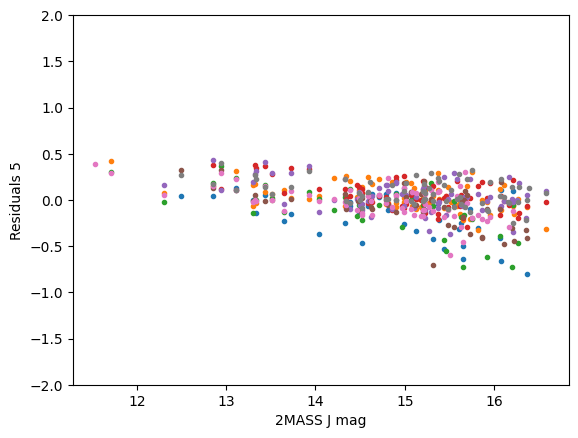

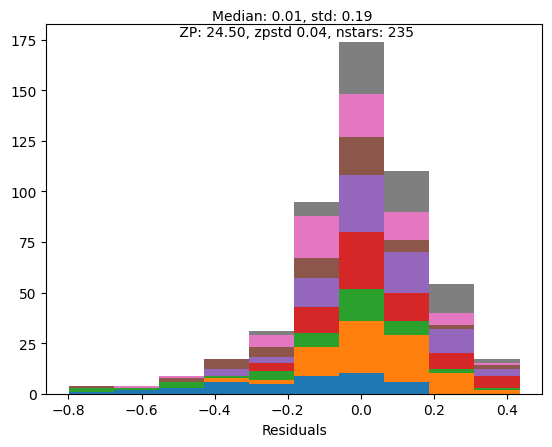

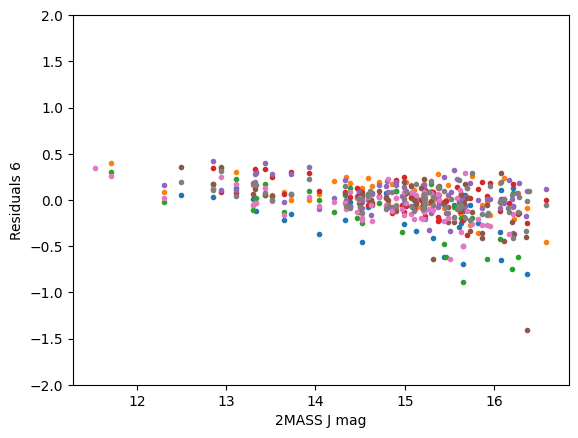

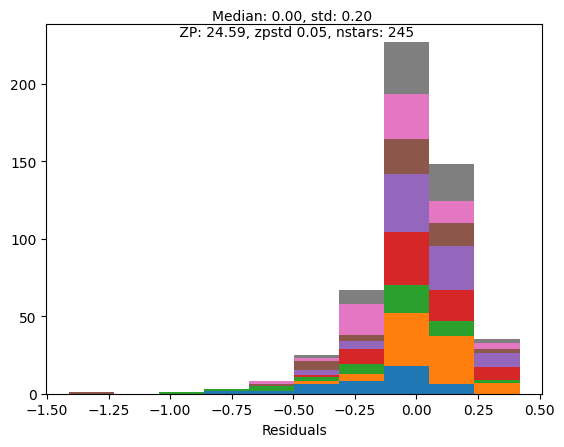

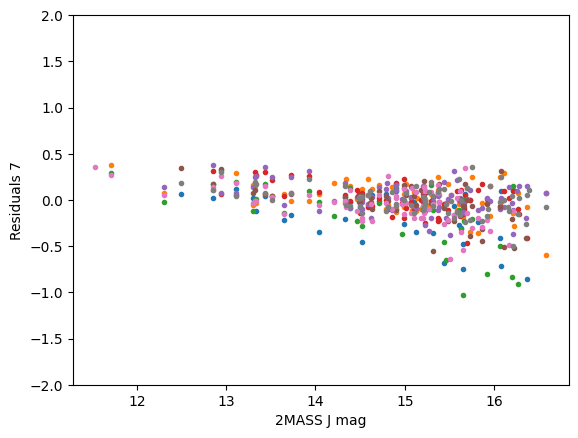

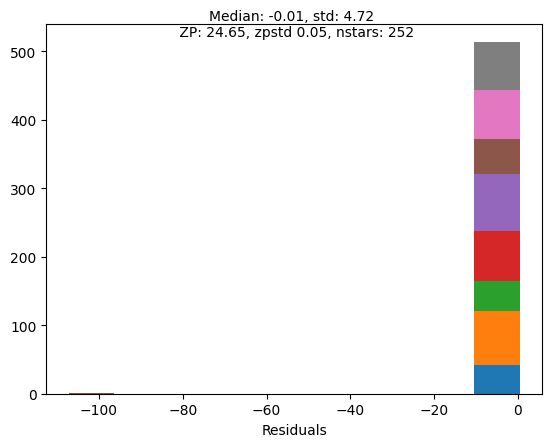

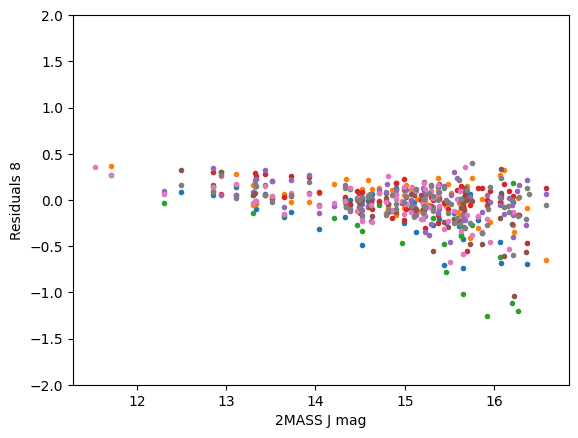

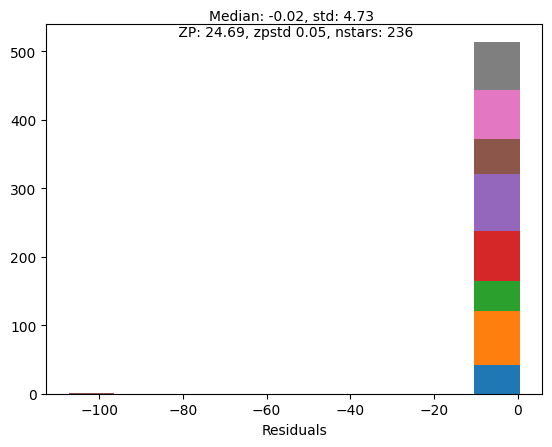

In [16]:
for ap in APER_RANGE:
    plt.figure()

    var = f'MAG_APER_{ap}'

    res_df_aper = []
    
    for key, (cat, ref) in all_xmatch.items():
        
        mags = cat[var]
        zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(mags, ref['j_m'], outlier_rejection_thresholds=[1.5])
        residuals = ref['j_m'] - mags - zp
        plt.plot(ref['j_m'], residuals, '.')
        res_df_aper.append({
            "residuals": [float(x) for x in residuals],
            "zp": zp,
            "zpstd": zpstd,
            "nstars": nstars
        })
        # plt.title(f"{zp:.2f}, {zpstd:.2f}, {key}")
    
    plt.ylabel(f'Residuals {ap}')
    plt.xlabel('2MASS J mag')
    plt.ylim(-2., 2.)
    plt.savefig(out_dir / f"residuals_aper_{ap}.pdf")
    
    res_df_aper = pd.DataFrame(res_df_aper)

    plt.figure()

    plt.hist(res_df_aper["residuals"], stacked=True)
    all_residuals = [x for y in res_df_aper["residuals"] for x in y]
    txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_aper["zp"].median():.2f}, zpstd {res_df_aper["zpstd"].median():.2f}, nstars: {res_df_aper["nstars"].sum()}")
    print(txt)
    plt.annotate(
        txt,
        xy=(0.5, 1.0),
        xycoords='axes fraction',
        ha='center',  
        va='center',
    )
    plt.xlabel("Residuals")
    plt.savefig(
        out_dir / f"hist_aper_{ap}.pdf",
        bbox_inches="tight",
)

# MAG_POINTSOURCE

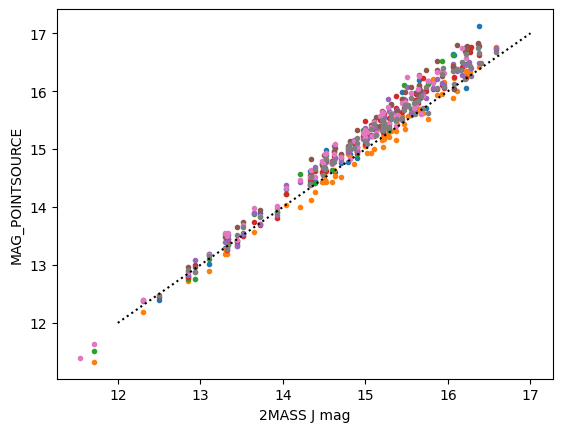

In [17]:
for key, (cat, ref) in all_xmatch.items():
    zp = all_zps[key]
    plt.plot(ref['j_m'], cat['MAG_POINTSOURCE'] + zp, '.')

plt.plot([12., 17.], [12., 17.], linestyle=":", color="k")
plt.ylabel('MAG_POINTSOURCE')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_ps.pdf")

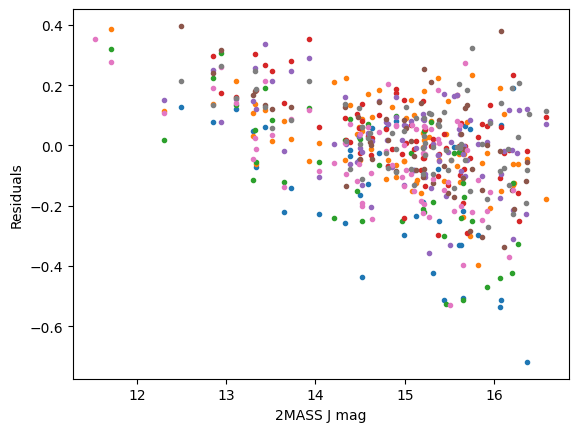

In [18]:
res_df_ps = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_POINTSOURCE'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_POINTSOURCE'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df_ps.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df_ps = pd.DataFrame(res_df_ps)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_ps.pdf")

Median: -0.00, std: 0.16 
 ZP: 24.66, zpstd 0.06, nstars: 248


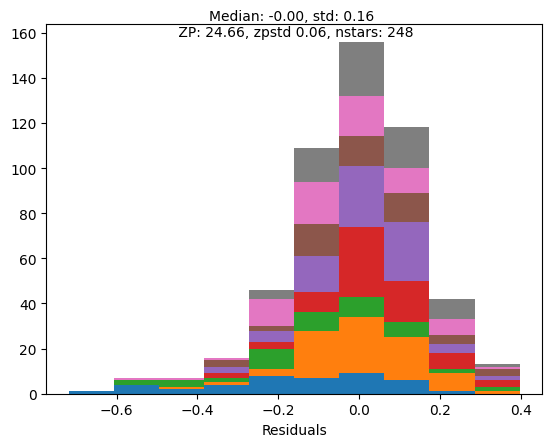

In [19]:
plt.hist(res_df_ps["residuals"], stacked=True)
all_residuals = [x for y in res_df_ps["residuals"] for x in y]
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_ps["zp"].median():.2f}, zpstd {res_df_ps["zpstd"].median():.2f}, nstars: {res_df_ps["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_ps.pdf",
    bbox_inches="tight",
)

In [20]:
cat

ALPHAWIN_J2000,DELTAWIN_J2000,X_IMAGE,Y_IMAGE,ELONGATION,ELLIPTICITY,XWIN_IMAGE,YWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,FLUX_RADIUS,FWHM_WORLD,FWHM_IMAGE,FLUX_AUTO,FLUXERR_AUTO,FLUX_MAX,MAG_AUTO,MAGERR_AUTO,FLUX_PSF,MAG_PSF,MAGERR_PSF,FLAGS,FLAGS_MODEL,FLAGS_WEIGHT,BACKGROUND,CLASS_STAR,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,VIGNET,SNR_WIN,XMODEL_IMAGE,YMODEL_IMAGE,FLUX_POINTSOURCE,FLUXERR_POINTSOURCE,MAG_POINTSOURCE,MAGERR_POINTSOURCE,FLUXRATIO_POINTSOURCE,FLUXRATIOERR_POINTSOURCE,CHI2_MODEL,NITER_MODEL,FLUX_MAX_MODEL,FLUX_MEAN_MODEL,SPREAD_MODEL,SPREADERR_MODEL,MAG_APER_2,FLUX_APER_2,MAG_APER_3,FLUX_APER_3,MAG_APER_4,FLUX_APER_4,MAG_APER_5,FLUX_APER_5,MAG_APER_6,FLUX_APER_6,MAG_APER_7,FLUX_APER_7,MAG_APER_8,FLUX_APER_8
deg,deg,pix,pix,,,pix,pix,pix,pix,pix,deg,pix,ct,ct,ct,mag,mag,ct,mag,mag,,,,ct,,ct,ct,mag,mag,ct,,pix,pix,ct,ct,mag,mag,,,,,ct,ct,,,,,,,,,,,,,,,,
float64,float64,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,uint8,int16,float32,float32,float32[7],float32[7],float32[7],float32[7],"float32[25,25]",float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
224.4488325,51.6247098,1795.4673,89.2937,1.315,0.239,1795.5806,89.1220,0.08051,0.07920,1.164,0.0009654576,3.17,2689.947,240.8816,474.288,-8.5744,0.0973,2338.278,-8.4222,0.0588,0,0,0,-0.5937977,0.011,1077.729 .. 2472.857,76.18106 .. 279.1175,-7.5813 .. -8.4830,0.0768 .. 0.1226,6.343812 .. 55.22041,18.5,1795.5309,88.9706,3313.936,204.1044,-8.8009,0.0669,1.00000,0.00000,0.9947183,47,1.980567e+09,1.980567e+09,-0.0031576,0.0028201,-7.581274,1077.7291,-8.126412,1780.5942,-8.41178,2315.8596,-8.544373,2616.6697,-8.589659,2728.1208,-8.563126,2662.2576,-8.482998,2472.8574
224.4772411,51.4983975,1732.0332,499.1046,1.737,0.424,1732.1439,499.2200,0.12597,0.12350,1.477,0.001075539,3.51,2702.117,228.1536,351.8305,-8.5793,0.0917,1938.243,-8.2185,0.0720,0,0,0,-7.483484,0.031,756.728 .. 2947.212,74.04426 .. 279.4313,-7.1973 .. -8.6735,0.1063 .. 0.1030,3.102199 .. -37.77349,14.71,1732.1491,498.8865,2418.277,184.5266,-8.4588,0.0829,1.00000,0.00000,0.9910568,96,1.445278e+09,1.445278e+09,0.0077544,0.0034944,-7.1973495,756.72797,-7.878773,1417.4553,-8.224629,1949.1785,-8.387273,2264.171,-8.52375,2567.438,-8.6185465,2801.6816,-8.673529,2947.2124
224.4782337,51.5417583,1731.4783,358.6740,1.401,0.286,1731.4442,358.7752,0.06222,0.06064,1.513,0.0009845388,3.21,5902.162,267.7775,695.0875,-9.4275,0.0493,4166.919,-9.0495,0.0354,0,0,0,-10.73178,0.027,1885.388 .. 5885.104,82.04179 .. 285.2694,-8.1885 .. -9.4244,0.0473 .. 0.0526,-22.47167 .. 41.81573,29.71,1731.4444,358.7526,5461.055,208.4449,-9.3432,0.0415,1.00000,0.00000,1.021175,46,2.814184e+09,2.814184e+09,-0.00025178,0.0014459,-8.188502,1885.3883,-8.692554,2999.3135,-9.012075,4025.5947,-9.190799,4745.9087,-9.316862,5330.2173,-9.379399,5646.2456,-9.424385,5885.1045
224.5051060,51.4672216,1674.3058,600.2901,1.150,0.131,1674.3722,600.2962,0.03127,0.03064,1.465,0.001047152,3.42,11578.6,313.5577,1205.879,-10.1591,0.0294,8447.642,-9.8168,0.0193,0,0,0,0.7217655,0.036,3183.614 .. 11498.46,88.93503 .. 295.3494,-8.7573 .. -10.1516,0.0303 .. 0.0279,30.87669 .. 78.00687,56.65,1674.5111,600.2453,10860.54,235.9443,-10.0896,0.0236,1.00000,0.00000,1.026152,30,5.596638e+09,5.596638e+09,0.0036561,0.00077755,-8.757301,3183.614,-9.446613,6006.8315,-9.849685,8707.104,-10.018839,10175.022,-10.088899,10853.239,-10.130871,11281.02,-10.1516,11498.463
224.5143133,51.5302211,1657.4447,396.3122,1.184,0.155,1657.5148,396.1669,0.00669,0.00624,1.430,0.0008604418,2.80,90179.7,446.4888,11601.08,-12.3878,0.0054,68214.77,-12.0847,0.0044,0,0,0,1.695623,0.673,28251.48 .. 88364.48,181.7612 .. 404.3502,-11.1276 .. -12.3657,0.0070 .. 0.0050,-33.4566 .. 49.38114,235.3,1657.5064,396.1519,89688.13,4

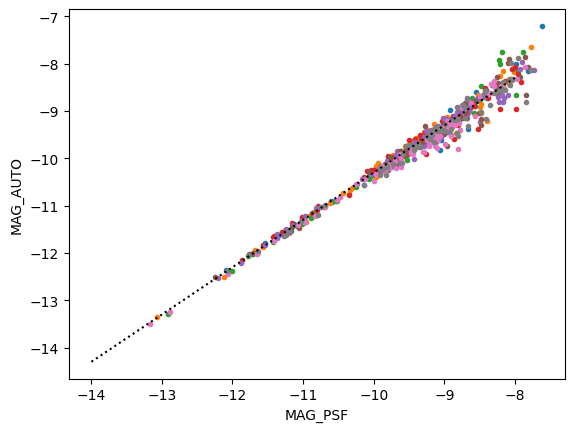

In [21]:
for (cat, ref) in all_xmatch.values():
    plt.plot(cat['MAG_PSF'], cat['MAG_AUTO'], '.')
plt.plot([-8., -14.], np.array([-8., -14.])-0.3, linestyle=":", color="k") 
plt.xlabel("MAG_PSF")
plt.ylabel("MAG_AUTO")
plt.savefig(out_dir / "auto_psf.pdf")

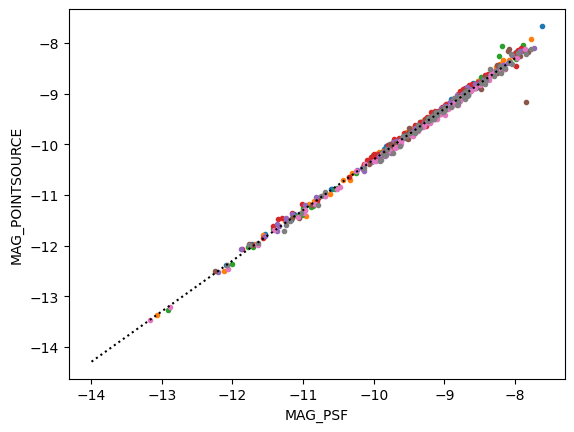

In [22]:
for (cat, ref) in all_xmatch.values():
    plt.plot(cat['MAG_PSF'], cat['MAG_POINTSOURCE'], '.')
plt.plot([-8., -14.], np.array([-8., -14.])-0.3, linestyle=":", color="k") 
plt.xlabel("MAG_PSF")
plt.ylabel("MAG_POINTSOURCE")
plt.savefig(out_dir / "ps_psf.pdf")

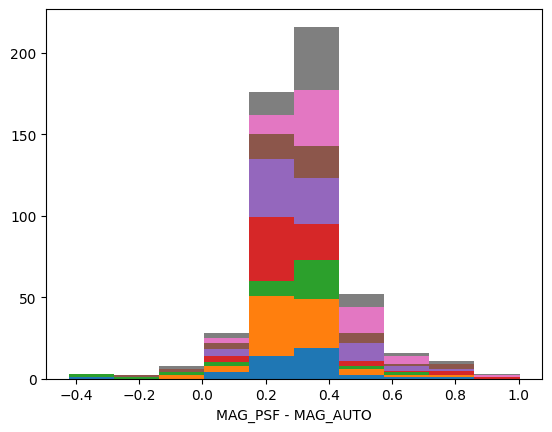

In [23]:
ratios = []
for (cat, ref) in all_xmatch.values():
    ratios.append(cat['MAG_PSF'] - cat['MAG_AUTO'])
plt.hist(ratios, stacked=True)
plt.xlabel("MAG_PSF - MAG_AUTO")
plt.savefig(out_dir / "auto_psf_hist.pdf")

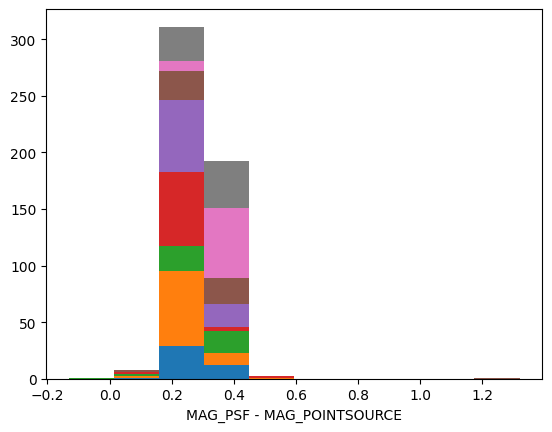

In [24]:
ratios = []
for (cat, ref) in all_xmatch.values():
    ratios.append(cat['MAG_PSF'] - cat['MAG_POINTSOURCE'])
plt.hist(ratios, stacked=True)
plt.xlabel("MAG_PSF - MAG_POINTSOURCE")
plt.savefig(out_dir / "auto_psf_hist.pdf")

In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u

def get_catalog_mags(crd: SkyCoord, cat, colname: str = 'MAG_AUTO', errcolname: str = 'MAGERR_AUTO'):
    cat_crds = SkyCoord(cat['ALPHAWIN_J2000'], cat['DELTAWIN_J2000'], unit=u.deg)
    idx, sep, _ = crd.match_to_catalog_sky(cat_crds)
    return cat[idx][colname], cat[idx][errcolname], cat[idx][colname.replace('MAG', 'FLUX')], cat[idx][errcolname.replace('MAG', 'FLUX')], cat[idx]['XWIN_IMAGE'], cat[idx]['YWIN_IMAGE'], sep.to(u.arcsec).value

def get_catalog_mags_from_list(crds, catlist, colname: str= 'MAG_AUTO', errcolname: str= 'MAGERR_AUTO', add_zp=True):
    mags = []
    magerrs = []
    fluxes = []
    fluxerrs = []
    xs, ys = [], []
    seps = []
    for (cat, zp) in catlist:
        mag, magerr, flux, fluxerr, x, y, sep = get_catalog_mags(crds, cat, colname=colname, errcolname=errcolname)
        if add_zp:
            mag += zp
        mags.append(mag)
        magerrs.append(magerr)
        fluxes.append(flux)
        fluxerrs.append(fluxerr)
        xs.append(x)
        ys.append(y)
        seps.append(sep)
    mags = np.array(mags)
    magerrs = np.array(magerrs)
    fluxes = np.array(fluxes)
    fluxerrs = np.array(fluxerrs)
    xs = np.array(xs)
    ys = np.array(ys)

    matchmask = np.array(seps)<2
    mags[~matchmask] = np.nan
    magerrs[~matchmask] = np.nan
    fluxes[~matchmask] = np.nan
    fluxerrs[~matchmask] = np.nan
    xs[~matchmask] = np.nan
    ys[~matchmask] = np.nan

    return mags, magerrs, fluxes, fluxerrs, xs, ys, seps


In [26]:
cats = [(x, all_zps[k]) for k, (x, _) in all_xmatch.items()]
ref_cat = ref

In [27]:
bright_ref_cat = ref_cat
# bright_ref_cat = bright_ref_cat[(bright_ref_cat['j_m']<14) & (bright_ref_cat['j_m']>13)]
bright_ref_cat_crds = SkyCoord(ra=bright_ref_cat['ra'], dec=bright_ref_cat['dec'], unit=(u.deg, u.deg))

In [28]:
bright_ref_cat

RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,pmDE,e_pmDE,RUWE,FG,e_FG,Gmag,FBP,e_FBP,phot_bp_mean_mag,FRP,e_FRP,phot_rp_mean_mag,BP-RP,RV,e_RV,Vbroad,GRVSmag,QSO,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,[Fe/H],Dist,A0,HIP,PS1,SDSS13,SKYM2,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,2MASS,RAVE6,RAJ2000_1,DEJ2000_1,RAJ2000_2,DEJ2000_2,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,Rflg,Bflg,Cflg,Xflg,Aflg,ra,dec,magnitude,magnitude_err,ra_errdeg,dec_errdeg
deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,,,mag,,,mag,mag,km / s,km / s,km / s,mag,,,,,,,,,,,,K,log(cm.s**-2),,pc,mag,,,,,,,,,,,,,deg,deg,deg,deg,mag,mag,mag,mag,mag,mag,,,,,,,deg,deg,mag,mag,mas,mas
float64,float64,int64,float64,float64,float64,float32,float64,float64,float32,float64,float32,float64,float64,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float32,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,float64,float64,float64,float64,float64,int32,int64,int64,int32,bytes12,bytes15,bytes19,int32,bytes10,bytes16,bytes17,bytes21,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bytes3,bytes3,bytes3,bytes3,uint8,uint8,float64,float64,float32,float32,float64,float64
224.44882722474,51.62475915002,1593406173595536256,0.0328,0.0300,0.7306,0.0369,15.487,10.811,0.039,-11.088,0.046,0.974,6784.22837,2.79,16.108616,3469,9.039,16.488062,4744,11.89,15.557623,0.930439,--,--,--,--,0,0,0,1,0,0,0,0,1,1,0,5332.1,4.6192,-0.7589,1050.9144,0.0390,--,169952244488350390,1237661418752573511,--,--,URAT1-709240020,J145747.71+513729.2,8833780,N669010824,--,14574771+5137292,--,224.44874982416,51.62480843164,224.448806,51.624798,15.866,0.040,15.407,0.063,15.440,0.072,AAA,222,111,000,0,0,224.44882722474,51.62475915002,15.866,0.040,0.0000,0.0000
224.47733180716,51.49850409995,1593356936090471296,0.0453,0.0450,0.5624,0.0531,6.967,-5.712,0.055,-3.990,0.066,1.342,4279.41674,2.855,16.608906,1946,9.18,17.115671,3453,11.57,15.902324,1.213347,--,--,--,--,0,0,0,1,0,0,0,0,1,1,0,4601.2,4.3561,-1.3213,1244.3425,0.0418,--,169792244773528860,1237661418752639095,--,--,URAT1-708236110,--,--,N669009874,--,14575456+5129544,--,224.47737258513,51.49852183155,224.477346,51.498466,15.935,0.046,15.352,0.063,15.404,0.074,AAA,222,111,000,0,0,224.47733180716,51.49850409995,15.935,0.046,0.0000,0.0000
224.47845333091,51.54177803361,1593358654077389824,0.0465,0.0496,2.5114,0.0584,75.629,-69.438,0.059,29.968,0.075,1.005,2912.13296,2.093,17.026838,668.2,10.06,18.276218,3411,9.215,15.915723,2.360496,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,--,--,--,--,--,--,169852244786390733,1237661418752573644,--,--,URAT1-708236111,J145754.87+513230.2,--,N669010218,--,14575493+5132296,--,224.47894953388,51.54164483995,224.478910,51.541580,15.316,0.030,14.795,0.043,14.540,0.044,AAA,222,111,000,0,0,224.47845333091,51.54177803361,15.316,0.030,0.0000,0.0000
224.50529047379,51.46705872502,1593356042737290112,0.0483,0.0486,3.5506,0.0550,10.130,-9.177,0.058,4.288,0.069,1.634,5799.74626,5.82,16.278845,1407,6.85,17.467604,6823,8.855,15.162999,2.304604,--,--,--,--,0,0,0,1,0,0,0,0,0,1,0,--,--,--,--,--,--,169762245053321104,1237661418752639121,--,--,URAT1-708236118,J145801.27+512801.4,--,N669009605,--,14580128+5128011,--,224.50535594812,51.46703966903,224.505340,51.466999,14.616,0.024,14.030,0.037,13.769,0.028,AAA,222,111,000,0,0,224.50529047379,51.46705872502,14.616,0.024,0.0000,0.0000
224.51427927203,51.53022871314,1593358477982437760,0.0098,0.0099,1.8309,0.0115,19.993,13.363,0.012,-14.872,0.014,1.161,191952.33557,36.33,12.479383,1.105e+05,48.11,12.730476,1.182e+05,41.63,12.066427,0.664049,17.18,2.19,--,11.884817,0,0,0,1,1,0,0,0,1,1,0,6139.7,4.1077,-0.8193,539.5505,0.0055,--,169832245142656968,1237661418752638985,--,3480-10-1,URAT1-708236121,J145803.42+513148.9,8833661,N669000265,--,14580339+5131487,--,224.51418380550,51.53029481011,224.514141,51.530220,12.495,0.019,12.241,0.029,12.1

# MAG_AUTO

Text(0.5, 0, 'Frame #')

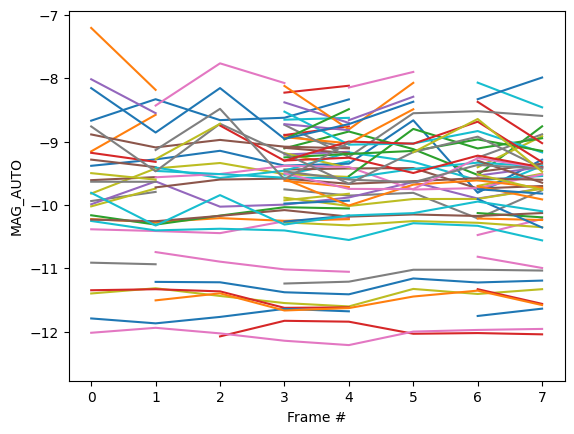

In [29]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, add_zp=False)
plt.plot(mags)
plt.ylabel(r'MAG_AUTO')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (AUTO)')

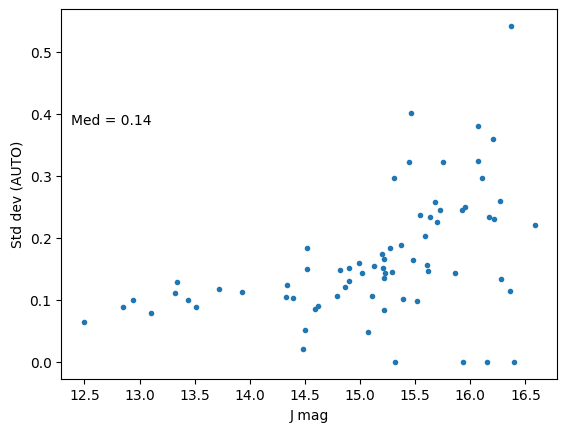

In [30]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (AUTO)')

Text(0.5, 0, 'Frame #')

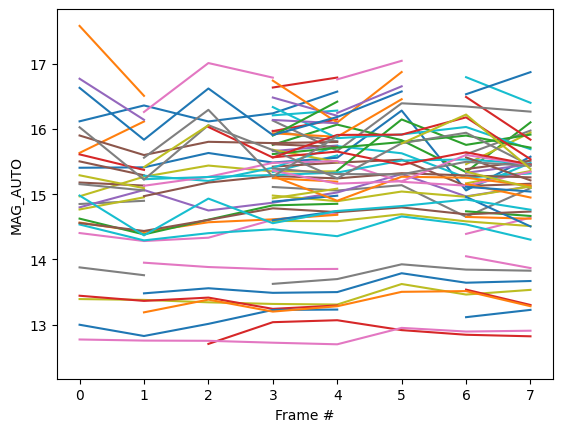

In [31]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, add_zp=True)
plt.plot(mags)
plt.ylabel(r'MAG_AUTO')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (AUTO)')

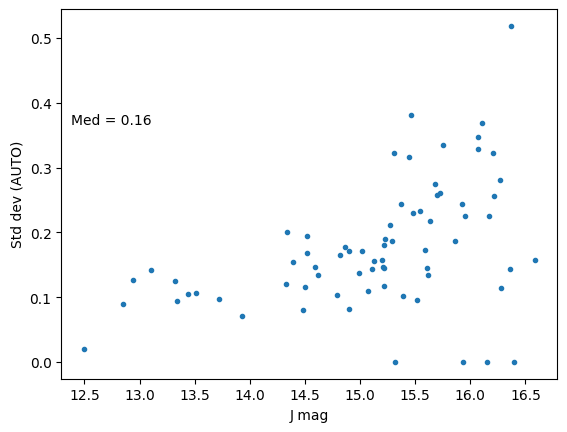

In [32]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (AUTO)')

# MAG_PSF

Text(0.5, 0, 'Frame #')

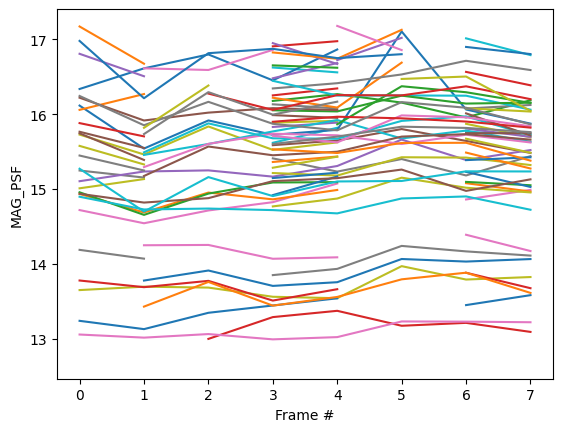

In [33]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, colname="MAG_PSF")
plt.plot(mags)
plt.ylabel(r'MAG_PSF')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (PSF)')

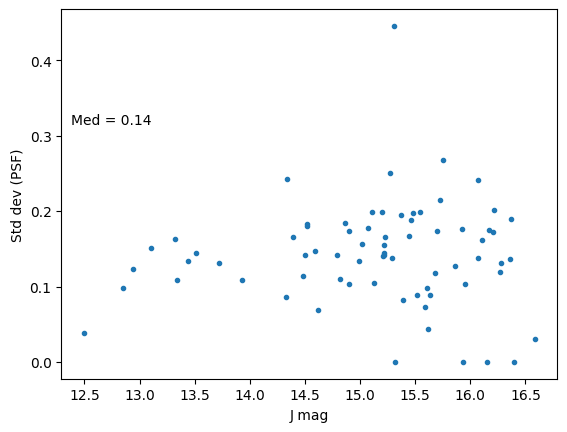

In [34]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (PSF)')

# MAG_POINTSOURCE

Text(0.5, 0, 'Frame #')

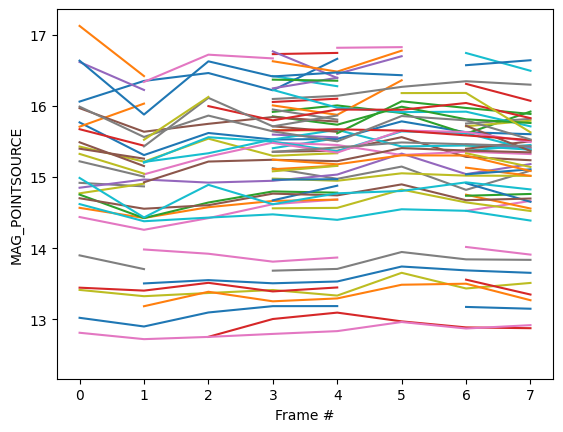

In [35]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, colname="MAG_POINTSOURCE")
plt.plot(mags)
plt.ylabel(r'MAG_POINTSOURCE')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (PS)')

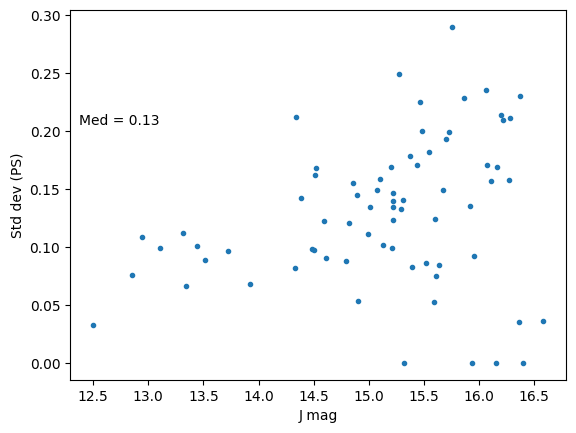

In [36]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (PS)')

# MAG_APER

In [37]:
for ap in APER_RANGE:
    var = f'MAG_APER_{ap}'

    mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, colname=var)
    stds = np.nanstd(mags, axis=0)

    med = f"Med = {np.median(stds):.2f}"

    print(var, med)


MAG_APER_2 Med = 0.14
MAG_APER_3 Med = 0.14
MAG_APER_4 Med = 0.15
MAG_APER_5 Med = 0.14
MAG_APER_6 Med = 0.14
MAG_APER_7 Med = 0.14
MAG_APER_8 Med = 0.14


In [38]:
def perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15, **kwargs):
    """
    Perform aperture photometry on a list of coordinates.
    :param image:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    image_data = fits.getdata(image)
    wcs = WCS(fits.getheader(astrometry_image))
    # Convert coordinates to pixel coordinates
    crds = crds.to_pixel(wcs)
    xs = crds[0]
    ys = crds[1]
    apertures = CircularAperture(np.column_stack((xs, ys)), r=aper_radius)
    # annulus_apertures = CircularAnnulus(np.column_stack((xs, ys)), r_in=annulus_bkg_in, r_out=annulus_bkg_out)

    bkg = Background2D(image_data, box_size=(50, 50), filter_size=(3, 3), **kwargs)
    bkg_mean = bkg.background_median
    # bkg_tab = aperture_photometry(image_data, annulus_apertures)

    # annulus_mask = annulus_apertures.to_mask(method='center')
    # annulus_bkg_data = annulus_mask[0].multiply(image_data)
    # annulus_bkg_median = np.nanmedian(annulus_bkg_data[annulus_bkg_data > 0])
    # phot_table_annulus = aperture_photometry(image_data - annulus_bkg_median, apertures)
    # Perform aperture photometry
    phot_table = aperture_photometry(image_data - bkg_mean, apertures, mask=np.isnan(image_data))

    return phot_table # phot_table_annulus

def perform_aperture_photometry_in_multiple_images(image_list, astrometry_image_list, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15, **kwargs):
    """
    Perform aperture photometry on a list of coordinates for a list of images.
    :param image_list:
    :param astrometry_image_list:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    phot_table_list = []
    for ind, image in enumerate(image_list):
        astrometry_image = astrometry_image_list[ind]
        phot_table = perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius, annulus_bkg_in, annulus_bkg_out, **kwargs)
        phot_table_list.append(phot_table)

    # Add image name to phot_table
    for ind, phot_table in enumerate(phot_table_list):
        phot_table['image'] = os.path.basename(image_list[ind])
        phot_table['astrometry_image'] = os.path.basename(astrometry_image_list[ind])

    # Make final table
    phot_table_list = np.hstack(phot_table_list)
    phot_table_df = pd.DataFrame(phot_table_list)
    return phot_table_df

def plot_aperture_phot_on_list(imagelist, astrometry_list, crds, aper_radius=5, **kwargs):
    phot_table = perform_aperture_photometry_in_multiple_images(imagelist, astrometry_list, crds, aper_radius=aper_radius, **kwargs)
    phot_table_grps = phot_table.groupby('id')
    std_values = []
    plt.figure()
    for name, group in phot_table_grps:
        mags = -2.5*np.log10(group['aperture_sum'].values)
        plt.plot(mags, label=name)
        std_values.append(np.nanstd(mags))

    return std_values, phot_table

In [39]:
imgs = list((target_dir.parent / "final").glob("WINTER*0.fits"))
imgs

[PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-072926-636_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-073548-506_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-073755-706_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-072719-143_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-074210-516_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-074002-803_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-073134-464_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20250220_C2/final/WINTERcamera_20250221-073341-459_mef_4_0_0.fits')]

In [40]:
# from astropy.io import fits

# for img_path in imgs:
#     with fits.open(img_path) as hdul:
#         print(hdul[0].header["TOBPORT"])

/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_50356/3795233498.py:66: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*np.log10(group['aperture_sum'].values)
/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_50356/3795233498.py:66: RuntimeWarning: invalid value encountered in log10
  mags = -2.5*np.log10(group['aperture_sum'].values)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1867: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


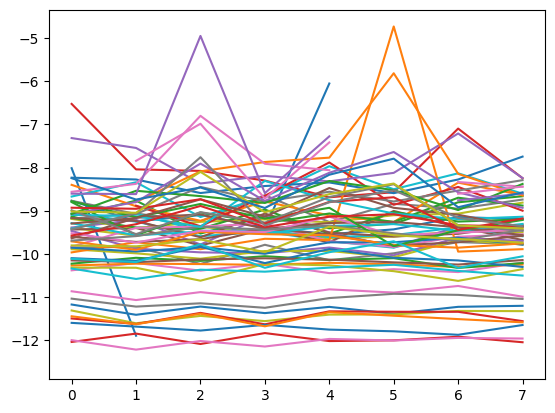

In [41]:
stds, df = plot_aperture_phot_on_list(imgs, imgs, bright_ref_cat_crds)

Text(0, 0.5, 'Std dev (FORCED_APER)')

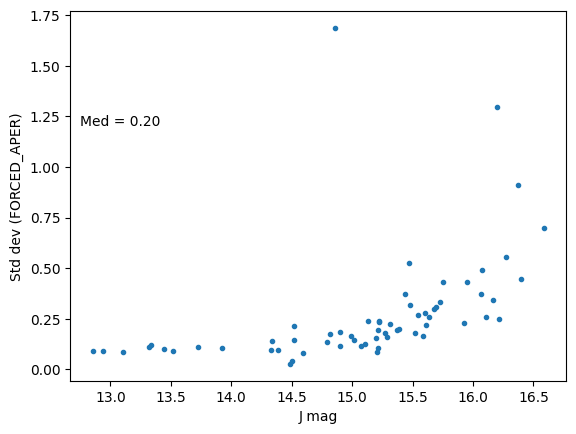

In [42]:
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.nanmedian(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (FORCED_APER)')

In [43]:
df

,id,xcenter,ycenter,aperture_sum,image,astrometry_image
0,1,1826.899548,139.878315,1604.163242,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
1,2,1763.499405,550.268332,0.000000,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
2,3,1762.438770,409.763641,0.000000,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
3,4,1705.618111,652.206885,9391.316616,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
4,5,1688.874461,447.132655,101188.358690,WINTERcamera_20250221-072926-636_mef_4_0_0.fits,WINTERcamera_20250221-072926-636_mef_4_0_0.fits
...,...,...,...,...,...,...
563,67,343.764014,995.360879,2373.369662,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits
564,68,297.450612,283.115643,5538.292698,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits
565,69,292.512045,557.371713,5809.147280,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits
566,70,215.449520,506.063084,10518.006689,WINTERcamera_20250221-073341-459_mef_4_0_0.fits,WINTERcamera_20250221-073341-459_mef_4_0_0.fits


/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **

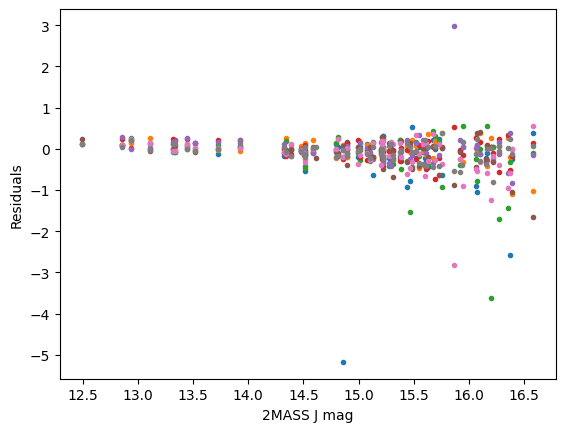

In [44]:
list(all_xmatch.keys())

res_df_forced = []

for key, (cat, ref) in all_xmatch.items():
    name = str(Path(key).with_suffix(".fits"))

    mask = df["image"] == name
    
    mags = -2.5 * np.log10(df["aperture_sum"][mask])

    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(mags, bright_ref_cat['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = bright_ref_cat['j_m'] - mags - zp
    plt.plot(bright_ref_cat['j_m'], residuals, '.')
    res_df_forced.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars,
    })

res_df_forced = pd.DataFrame(res_df_forced)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_forced.pdf")

Median: -0.04, std: 0.45 
 ZP: 24.76, zpstd 0.07, nstars: 254


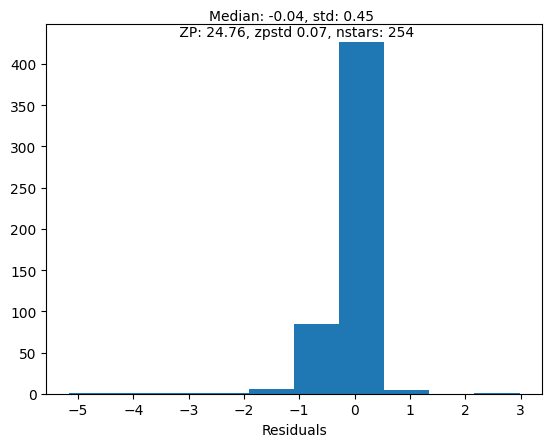

In [45]:
all_residuals = [x for y in res_df_forced["residuals"] for x in y if pd.notnull(x) & np.isfinite(x)]
plt.hist(all_residuals)
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_forced["zp"].median():.2f}, zpstd {res_df_forced["zpstd"].median():.2f}, nstars: {res_df_forced["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_forced.pdf",
    bbox_inches="tight",
)

In [46]:
# results = dict()
# results[